## The Task

What makes a playlist successful? Please evaluate the data and prepare your findings, aimed at a business-focused, non-technical audience. How you define and plan the analysis is up to you, and you are free to use any tools you want to complete the task.

## The Data
The data set contains simulated data for a sample of playlists.  The following table describes the fields available in the data set.

| Column Name             | Description                                                                                                                             |
|-------------------------|-----------------------------------------------------------------------------------------------------------------------------------------|
| playlist_uri            | The key, uri of the playlist                                                                                                            |
| owner                   | Playlist owner, username                                                                                                                |
| streams                 | Number of streams from playlist today                                                                                                   |
| stream30s               | Number of streams over 30 seconds from  playlist today                                                                                  |
| dau                     | Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today                                              |
| wau                     | Number of Weekly Active Users, i.e. users with a stream over 30 seconds from playlist in past week                                      |
| mau                     | Number of Monthly Active Users, i.e. users with a stream over 30 seconds from playlist in past month                                    |
| mau_previous_month      | Number of Monthly Active Users in the month prior to this one                                                                           |
| mau_both_months         | Number of users that were active on the playlist both this and the previous month                                                       |
| users                   | Users streaming at least one stream of any time duration (including skipped streams) in past month                                      |
| skippers                | Number of users who skipped more than 90 percent of their total streams today and also used this playlist                               |
| owner_country           | Country of playlist owner                                                                                                               |
| n_tracks                | Number of tracks in playlist                                                                                                            |
| n_local_tracks          | Change in number of local file tracks on playlist since yesterday Number of tracks on the playlist that are new from yesterday to today |
| n_artists               | Number of unique artists in playlist                                                                                                    |
| n_albums                | Number of unique albums in playlist                                                                                                     |
| monthly_stream30s       | Number of streams over 30 seconds this month                                                                                            |
| monthly_owner_stream30s | Number of streams over 30 seconds by playlist owner this month                                                                          |
| tokens                  | List of playlist title tokens, stopwords and punctuation removed                                                                        |
| genre_1                 | No. 1 Genre by weight of playlist tracks, from Gracenote metadata                                                                       |
| genre_2                 | No. 2 Genre by weight of playlist tracks, from Gracenote metadata                                                                       |
| genre_3                 | No. 3 Genre by weight of playlist tracks, from Gracenote metadata                                                                       |
| mood_1                  | No. 1 Mood by weight of playlist tracks, from Gracenote metadata                                                                        |
| mood_2                  | No. 2 Mood by weight of playlist tracks, from Gracenote metadata                                                                        |
| mood_3                  | No. 3 Mood by weight of playlist tracks, from Gracenote metadata

## The Approach
A playlist is successful if it engages the user.  Engagement can be measured in the following three ways.

* Monthly organic stream 30s = *monthly_stream30s - monthly_owner_stream30s*
* Monthly organic stream 30s per user = *monthly_stream30s_organic / (users - 1)*
* Average number of tracks played per user = *monthly_stream30s_organic / ((users - 1) * n_tracks)*; variable name is monthly_organic_stream30s_per_track_user

Can we explain each of these metrics as a function of a playlist's features, specifically the number of tracks, artists, albums as well and genre and mood? To accomplish this, we can use regression models to generate coefficients that measure the impact of these features on each engagement metric.

In [1]:
%matplotlib inline
import importlib
from IPython.display import display, HTML, Image, clear_output
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta
from time import time
import random
from itertools import product
import subprocess
from collections import defaultdict
import re
import ast
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
import prince
from scipy import stats
import itertools
from joblib import Parallel, delayed 
import gc
import warnings
import pdb

warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '{0:4f}'.format(x))

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [2]:
def reduce_df_mem(df_large, verbose=True, ignore_columns=[], ignore_date_columns=[], categorize_str_dates=True):
    """Reduces the memory footprint of a Pandas dataframe by downcasting numeric columns"""
    df = df_large.copy()
    
    int_cols = df.select_dtypes(include=['int']).columns
    
    for i, int_col in enumerate(int_cols):
        if int_col in ignore_columns:
            continue

        if verbose:
            clear_output(wait=True)
            print(int_col)
            print('INT COLUMNS: {0} out of {1}'.format(i+1, len(int_cols)))
        
        df[int_col] = pd.to_numeric(df[int_col], downcast='signed')
        
    float_cols = df.select_dtypes(include=['float']).columns
    
    for j, float_col in enumerate(float_cols):
        if float_col in ignore_columns:
            continue

        if verbose:
            clear_output(wait=True)
            print(float_col)
            print('FLOAT COLUMNS: {0} out of {1}'.format(j+1, len(float_cols)))
        
        df[float_col] = pd.to_numeric(df[float_col], downcast='float')
        
    obj_cols = df.select_dtypes(include=['object']).columns
    
    for k, obj_col in enumerate(obj_cols):
        if obj_col in ignore_columns:
            continue

        if verbose:
            clear_output(wait=True)
            print(obj_col)
            print('OBJECT COLUMNS: {0} out of {1}'.format(k+1, len(obj_cols)))
        
        unique_values = df[obj_col].unique()
        
        for unique_value in unique_values:
            if pd.isnull(unique_value):
                continue
            else:
                break
        
        if not isinstance(unique_value, str):
            continue
        
        try:
            dt = dateutil.parser.parse(unique_value)

            if obj_col in ignore_date_columns and categorize_str_dates:
                pass
            elif obj_col in ignore_date_columns and not categorize_str_dates:
                continue
            else:
                df[obj_col] = pd.to_datetime(df[obj_col])
                continue
        except:
            pass
        
        num_unique_values = len(unique_values)
        num_total_values = len(df[obj_col])
        
        if num_unique_values / num_total_values < 0.5:
            df[obj_col] = df[obj_col].astype('category')

    gc.collect()
    
    return df

In [3]:
def fit_linear_regression(model, X, y):
    """Wrapper function for sklearn linear regression models to get t stats, f stats, and p values"""
    model.fit(X, y)
    y_pred = model.predict(X)

    intercept = model.intercept_
    coefs = model.coef_
    
    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    r2 = metrics.r2_score(y, y_pred)

    beta_hat = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    epsilon = y - np.dot(X, beta_hat)
    dof = X.shape[0] - X.shape[1]
    sigma_hat = np.sqrt(np.dot(epsilon, epsilon) / dof)
    s = sigma_hat * np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, X)), 0))
    conf_intervals = np.add(np.tile(beta_hat, (2,1)).T, s.reshape(s.shape[0], 1) * np.array(stats.t.interval(0.95, dof)))
    t_stat = beta_hat / s
    p_value = stats.t.sf(abs(t_stat), dof) * 2
    y_hat = np.dot(X, beta_hat)
    y_mu = np.mean(y)
    mean_SSR = np.dot((y_hat - y_mu).T, (y_hat - y_mu)) / (len(beta_hat) - 1)
    f_stat = mean_SSR / np.square(sigma_hat)
    f_stat_p_value = stats.f.sf(abs(f_stat), dfn=(len(beta_hat) - 1), dfd=dof)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'intercept': ('intercept', intercept, t_stat[0], p_value[0]),
        'coefs': list(zip(X.columns, coefs, t_stat[1:], p_value[1:])),
        't_stat': t_stat,
        'p_values': p_value,
        'y_hat': y_hat,
        'f_stat': f_stat,
        'f_stat_p_value': f_stat_p_value,
        'params': pd.DataFrame([('intercept', intercept, t_stat[0], p_value[0])] + list(zip(X.columns, coefs, t_stat[1:], p_value[1:])), 
                               columns=['feature', 'coef', 't_stat', 'p_value']),
    }

In [4]:
def fit_quantile_regression(X, y, quantile):
    """Wrapper function for statsmodels quantile regression models to get t stats, f stats, and p values"""
    model = QuantReg(y, X)
    res = model.fit(q=quantile)
    y_pred = res.predict(X)

    intercept = res.params.values[0]
    coefs = res.params.values[1:]
    
    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    r2 = metrics.r2_score(y, y_pred)

    beta_hat = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    epsilon = y - np.dot(X, beta_hat)
    dof = X.shape[0] - X.shape[1]
    sigma_hat = np.sqrt(np.dot(epsilon, epsilon) / dof)
    s = sigma_hat * np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, X)), 0))
    conf_intervals = np.add(np.tile(beta_hat, (2,1)).T, s.reshape(s.shape[0], 1) * np.array(stats.t.interval(0.95, dof)))
    t_stat = beta_hat / s
    p_value = stats.t.sf(abs(t_stat), dof) * 2
    y_hat = np.dot(X, beta_hat)
    y_mu = np.mean(y)
    mean_SSR = np.dot((y_hat - y_mu).T, (y_hat - y_mu)) / (len(beta_hat) - 1)
    f_stat = mean_SSR / np.square(sigma_hat)
    f_stat_p_value = stats.f.sf(abs(f_stat), dfn=(len(beta_hat) - 1), dfd=dof)

    return {
        'results': res,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'intercept': ('intercept', intercept, t_stat[0], p_value[0]),
        'coefs': list(zip(res.params.index[1:], coefs, t_stat[1:], p_value[1:])),
        't_stat': t_stat,
        'p_values': p_value,
        'y_hat': y_hat,
        'f_stat': f_stat,
        'f_stat_p_value': f_stat_p_value,
        'params': pd.DataFrame([('intercept', intercept, t_stat[0], p_value[0])] + list(zip(res.params.index[1:], coefs, t_stat[1:], p_value[1:])), 
                               columns=['feature', 'coef', 't_stat', 'p_value']),
    }

In [5]:
def fit_ensemble_regression(model, X, y):
    """Wrapper function for sklearn tree regression models to get t stats, f stats, and p values"""
    model.fit(X, y)
    y_pred = model.predict(X)
    
    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    r2 = metrics.r2_score(y, y_pred)

    beta_hat = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    epsilon = y - np.dot(X, beta_hat)
    dof = X.shape[0] - X.shape[1]
    sigma_hat = np.sqrt(np.dot(epsilon, epsilon) / dof)
    s = sigma_hat * np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, X)), 0))
    conf_intervals = np.add(np.tile(beta_hat, (2,1)).T, s.reshape(s.shape[0], 1) * np.array(stats.t.interval(0.95, dof)))
    t_stat = beta_hat / s
    p_value = stats.t.sf(abs(t_stat), dof) * 2
    y_hat = np.dot(X, beta_hat)
    y_mu = np.mean(y)
    mean_SSR = np.dot((y_hat - y_mu).T, (y_hat - y_mu)) / (len(beta_hat) - 1)
    f_stat = mean_SSR / np.square(sigma_hat)
    f_stat_p_value = stats.f.sf(abs(f_stat), dfn=(len(beta_hat) - 1), dfd=dof)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        't_stat': t_stat,
        'p_values': p_value,
        'y_hat': y_hat,
        'f_stat': f_stat,
        'f_stat_p_value': f_stat_p_value,
        'feature_importances': sorted(list(zip(X.columns, model.feature_importances_)), key=lambda x: x[1], reverse=True),
    }

In [6]:
def run_ensemble_regression(X, y, n_samples_num=1000, n_samples_cat=5000, n_jobs=28):
    """Run tree regression model and generate pseudo coefficients using bootstrap predictions
       Subtract bootstrap predictions from baseline prediction to get actual coefficients
    """
    reg = RandomForestRegressor(random_state=random_state, n_jobs=n_jobs)

    results_ensmb_reg = fit_ensemble_regression(reg, X, y)
    
    num_feature_coefs = []

    results_num_features = Parallel(n_jobs=n_jobs, verbose=0, prefer='threads')\
                           (delayed(get_bootstrap_num_feature_pred_pctiles)(reg, num_feature, n_samples=n_samples_num) for num_feature in number_feature_columns)

    for i, result in enumerate(results_num_features):
        num_feature_coefs.append((number_feature_columns[i], np.median(np.array(result))))
    
    df_num_feature_coefs = pd.DataFrame(num_feature_coefs, columns=['feature', 'coef']) 
    
    bin_features_to_run = []
    bin_feature_coefs = {}

    for bin_feature, bin_importance in results_ensmb_reg['feature_importances'] + [('genre_mood_1_trunc_other|other', 1)]:
        if 'genre_mood' not in bin_feature:
            continue

        bin_features_to_run.append(bin_feature)
        
    bin_results = Parallel(n_jobs=n_jobs, verbose=0, prefer='threads')\
                  (delayed(get_bootstrap_bin_feature_pred_pctiles)(reg, bin_feature, n_samples=n_samples_cat) for bin_feature in bin_features_to_run)

    for bin_result in bin_results:
        bin_feature_coefs.update(bin_result)
        
    ensmb_reg_pctile_diffs = []

    for bin_feature, bin_importance in results_ensmb_reg['feature_importances']:
        if 'genre_mood' not in bin_feature:
            continue

        ensmb_reg_pctile_diffs.append((bin_feature, np.mean(np.array(bin_feature_coefs[bin_feature]) - np.array(bin_feature_coefs['genre_mood_1_trunc_other|other']))))

    df_ensmb_reg_pctile_diffs = pd.DataFrame(ensmb_reg_pctile_diffs, columns=['feature', 'coef'])
    
    return pd.concat([df_num_feature_coefs, df_ensmb_reg_pctile_diffs]).sort_values(['coef'], ascending=False), results_ensmb_reg['r2'], results_ensmb_reg['f_stat_p_value']  

In [7]:
def get_bootstrap_bin_feature_pred_pctiles(reg, feature, n_samples=1000):
    """Generate bootstrap sample of training data set and make predictions for different
       values of binary feature holding all other features constant.  Return 25th, 50th, and 75th
       percentile of predictions.
    """
    df_temp = df_ensmb_reg.sample(n=n_samples, replace=True)
    preds = []
    
    for i, row in df_temp.iterrows():
        for col in df_temp.columns:
            if 'genre_mood' in col:
                row[col] = 0
            
        row[feature] = 1
    
        y_pred = reg.predict(row.values.reshape(1, -1))
    
        preds.append(y_pred[0])
        
    return {feature: [sorted(preds)[int(0.25 * n_samples)], sorted(preds)[int(0.50 * n_samples)], sorted(preds)[int(0.75 * n_samples)]]}

In [8]:
def get_bootstrap_num_feature_pred_pctiles(reg, feature, n_samples=1000):
    """Generate bootstrap sample of training data set and make predictions for different
       values of numeric feature holding all other features constant.  Return 25th, 50th, and 75th
       percentile of predictions.
    """
    
    df_temp = df_ensmb_reg.sample(n=n_samples, replace=True)
    quantiles = df_ensmb_reg[feature].quantile(np.linspace(0.1, 0.9, 9))

    preds = []

    for i, row in df_temp.iterrows():
        y_preds = []

        for quantile in quantiles:
            row[number_feature_column] = quantile

            y_pred = reg.predict(row.values.reshape(1, -1))
            y_preds.append(y_pred[0])
            
        slope, intercept, r_value, p_value, std_err = stats.linregress(quantiles, y_preds)

        preds.append(slope)

    return preds

## Exploratory Data Analysis
This is done in order to better inform feature and model selection.  Histograms of each data element are drawn to visual how the data is distributed.  Scatter plots of numeric features and engagement metrics are drawn to determine what type of relationship if any exist.  Similarly, bar charts are drawn to see the relationship between categorical features and engagement metrics.

In [9]:
random_state = 17

In [10]:
#Load playlist data and drop token field because of sparsity
df = pd.read_csv('playlist_summary_external.txt', sep='\t', header=0, quotechar='"')
df = df.drop(['tokens'], axis=1)

In [11]:
#Who owns top performing playlists?
user_col = 'users'
df_owner = df.groupby(['owner']).agg({'owner': 'count', 'monthly_stream30s': 'sum', 'monthly_owner_stream30s': 'sum', user_col: 'sum'}).sort_values([user_col], ascending=False)
df_owner = df_owner.rename(columns={'owner': 'num_playlists'})
df_owner['monthly_stream30s_organic'] = df_owner.monthly_stream30s - df_owner.monthly_owner_stream30s
df_owner['monthly_stream30s_per_' + user_col] = df_owner.monthly_stream30s / df_owner[user_col]
df_owner['monthly_stream30s_organic_per_' + user_col] = df_owner.monthly_stream30s / (df_owner[user_col] - 1)
df_owner['pct_of_streams'] = df_owner.monthly_stream30s / df_owner.monthly_stream30s.sum()
df_owner['pct_of_organic_streams'] = df_owner.monthly_stream30s_organic / df_owner.monthly_stream30s_organic.sum()
df_owner['pct_of_' + user_col] = df_owner[user_col] / df_owner[user_col].sum()
df_owner = reduce_df_mem(df_owner, verbose=False)
df_owner[df_owner[user_col] >= 10].sort_values(['monthly_stream30s_organic'], ascending=False).head()

num_playlists  monthly_stream30s  monthly_owner_stream30s     users  monthly_stream30s_organic  monthly_stream30s_per_users  monthly_stream30s_organic_per_users  pct_of_streams  pct_of_organic_streams  pct_of_users
owner                                                                                                                                                                                                                                                   
musicco                                     399          365656216                      594  46998930                  365655622                     7.780097                             7.780097        0.719175                0.776833      0.780377
a19ebea5b5c28f3eff7f45167f7f3b1c              9            5622453                      104    511937                    5622349                    10.982705                            10.982726        0.011058                0.011945      0.008500
e60d19313a8df36c7e6cf59e259e0d66             31            4577553                       35    733406                    4577518                     6.241499                             6.241508        0.009003                0.009725      0.012178
6987037f34b5cee787a1a5e8de9b2689             48            3199034                      237    390355                    3198797                     8.195191                             8.195212        0.006292                0.006796      0.006482
dc3bdd3ea9a21cddc050e8b1c7240c63              5            1790946                      771     74394                    1790175                    24.073797                            24.074120        0.003522                0.003803      0.001235

Total playlist streams are dominated by company created playlists when looking at total streams and total users.  As a result, to maximize user engagement, the company should focus on the characteristics and construction of its own curated playlists.

In [12]:
#Engineer several new features and engagement metrics
df['monthly_stream30s_per_user'] = df.monthly_stream30s / df.users
df['monthly_stream30s_organic'] = df.monthly_stream30s - df.monthly_owner_stream30s
df['monthly_stream30s_organic_per_user'] = df.monthly_stream30s_organic / (df.users - 1)
df['monthly_stream30s_per_track_user'] = 100 * df.monthly_stream30s / ((df.users - 1) * df.n_tracks)
df['monthly_stream30s_organic_per_track_user'] = 100 * df.monthly_stream30s_organic / ((df.users - 1) * df.n_tracks)
df['tracks_per_artist'] = df.n_tracks / df.n_artists
df['tracks_per_album'] = df.n_tracks / df.n_albums
df['wau_mau'] = (df.wau * 30 / 7) / df.mau
df['dau_mau'] = 30 * df.dau / df.mau
df = reduce_df_mem(df, verbose=False)

In [13]:
text_columns = ['playlist_uri', 'owner', 'owner_country']
genre_columns = ['genre_1', 'genre_2', 'genre_3']
mood_columns = ['mood_1', 'mood_2', 'mood_3']
genre_mood_columns = ['genre_mood_1', 'genre_mood_2', 'genre_mood_3', 'genre_mood']
number_feature_columns = ['n_tracks', 'n_local_tracks', 'n_artists', 'n_albums', 'tracks_per_artist', 'tracks_per_album']
target_columns = ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'mau_both_months', 'users', 'skippers',
                  'monthly_stream30s', 'monthly_owner_stream30s', 'monthly_stream30s_per_user', 'monthly_stream30s_per_track_user',
                  'monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user',
                  'wau_mau', 'dau_mau', ]

Because genre and mood labels are concomitant, it makes sense to create a new feature that is the concatenation of genre and mood labels for each of the levels.  A feature that is the concatenation of all genre and mood labels is also created because of a concomitance across genre and mood levels.  In order to reduce the dimensionality of this new feature set, only the top combinations of genre and mood labels are kept.  The remaining labels are grouped together and tagged as "Other".

In [14]:
for col in genre_columns + mood_columns:
    df_temp = df.groupby([col], as_index=False).agg({'monthly_stream30s_organic': 'sum', 'users': 'sum'}).sort_values(['monthly_stream30s_organic'], ascending=False)
    df_temp['pct_total'] = df_temp.monthly_stream30s_organic / df_temp.monthly_stream30s_organic.sum()
    df_temp['cum_pct_total'] = df_temp.pct_total.cumsum()
    temp_dict = dict(zip(df_temp[df_temp.cum_pct_total > 0.95][col], [1]*len(df_temp[df_temp.cum_pct_total > 0.95])))
    df[col + '_trunc'] = df[col].apply(lambda x: 'Other' if x in temp_dict else x)

In [15]:
df['genre_mood_1'] = df.genre_1.str.cat(df.mood_1, sep='|')
df['genre_mood_2'] = df.genre_2.str.cat(df.mood_2, sep='|')
df['genre_mood_3'] = df.genre_3.str.cat(df.mood_3, sep='|')
df['genre_mood'] = df.genre_mood_1.str.cat(df.genre_mood_2, sep='|').str.cat(df.genre_mood_3, sep='|')

In [16]:
for col in genre_mood_columns:
    df_temp = df.groupby([col], as_index=False).agg({'monthly_stream30s_organic': 'sum', 'users': 'sum'}).sort_values(['monthly_stream30s_organic'], ascending=False)
    df_temp['pct_total'] = df_temp.monthly_stream30s_organic / df_temp.monthly_stream30s_organic.sum()
    df_temp['cum_pct_total'] = df_temp.pct_total.cumsum()
    temp_dict = dict(zip(df_temp[df_temp.pct_total < 0.001][col], [1]*len(df_temp[df_temp.pct_total < 0.001])))
    
    if col == 'genre_mood':
        df[col + '_trunc'] = df[col].apply(lambda x: 'Other|Other|Other|Other|Other|Other' if x in temp_dict else x)
    else:
        df[col + '_trunc'] = df[col].apply(lambda x: 'Other|Other' if x in temp_dict else x)

In [17]:
pctiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
df.describe(pctiles)

streams      stream30s           dau           wau            mau  mau_previous_month  mau_both_months          users      skippers      n_tracks  n_local_tracks     n_artists      n_albums  monthly_stream30s  monthly_owner_stream30s  monthly_stream30s_per_user  monthly_stream30s_organic  monthly_stream30s_organic_per_user  monthly_stream30s_per_track_user  monthly_stream30s_organic_per_track_user  tracks_per_artist  tracks_per_album       wau_mau       dau_mau
count  403366.000000  403366.000000 403366.000000 403366.000000  403366.000000       403366.000000    403366.000000  403366.000000 403366.000000 403366.000000   403366.000000 403366.000000 403366.000000      403366.000000            403366.000000               403366.000000              403366.000000                       403366.000000                     403366.000000                             403366.000000      403366.000000     403366.000000 403366.000000 403366.000000
mean       71.013752      42.833333      4.418265     21.784446      66.142895           58.190088        12.937065     149.308467      2.827749    201.483432        3.084035     83.852050     88.224250        1260.488586                93.556621                   38.180832                1166.931965                           21.286961                         94.114227                                 31.469397          11.876744          8.074166      1.952800      5.003272
std      6492.013742    3772.412203    358.855685   1614.650805    4732.580187         3827.248092      1240.912979    9247.483569    205.059728    584.077765       40.330266    128.152488    133.193118      106246.292506               226.250189                   75.892464              106246.650829                           67.645020                       1353.856079                                138.214981          98.817879         74.182053      1.075699      6.499850
min         0.000000       0.000000      0.000000      0.000000       2.000000            0.000000         0.000000       2.000000      0.000000      1.000000        0.000000      1.000000      1.000000           2.000000                 0.000000                    0.030769                   1.000000                            0.016393                          0.003024                                  0.000833           1.000000          1.000000      0.000000      0.000000
1%          0.000000       0.000000      0.000000      0.000000       2.000000            0.000000         0.000000       2.000000      0.000000      6.000000        0.000000      1.000000      1.000000           3.000000                 0.000000                    0.666667                   1.000000                            0.300000                          0.547445                                  0.111111           1.000000          1.000000      0.000000      0.000000
5%          0.000000       0.000000      0.000000      0.000000       2.000000            0.000000         0.000000       2.000000      0.000000     13.000000        0.000000      1.000000      1.000000           8.000000                 0.000000                    1.666667                   2.000000                            0.666667                          1.893939                                  0.431151           1.000000          1.000000      0.000000      0.000000
10%         0.000000       0.000000      0.000000      0.000000       2.000000            1.000000         0.000000       2.000000      0.000000     19.000000        0.000000      3.000000      6.000000          13.000000                 1.000000                    2.769231                   3.000000                            1.000000                          3.529733                                  0.868364           1.055556          1.043478      0.000000      0.000000
25%         0.000000       0.000000      0.000000      1.000000       2.000000            1.000000         1.000000       2.000000      0.000000     38.000000        0.000000     18

The descriptive statistics of the numeric features and engagement metrics show a wide range of values for each with concentrations at low values for each.  Mosts playlists have small numbers of users and therefore small amount of streams.  In terms of playlist construction, playlist appear to be varied with respect to number of artists and albums that appear.  Most playlists appear to be lengthy with the median number of tracks being 84.

Below is a correlation heatmap to uncover potential multicollinearity among numeric features in the feature set.  Note that a feature's correlation with each of the engagement metrics will give an indication of what to expect in terms of the sign of that feature's regression coefficient.

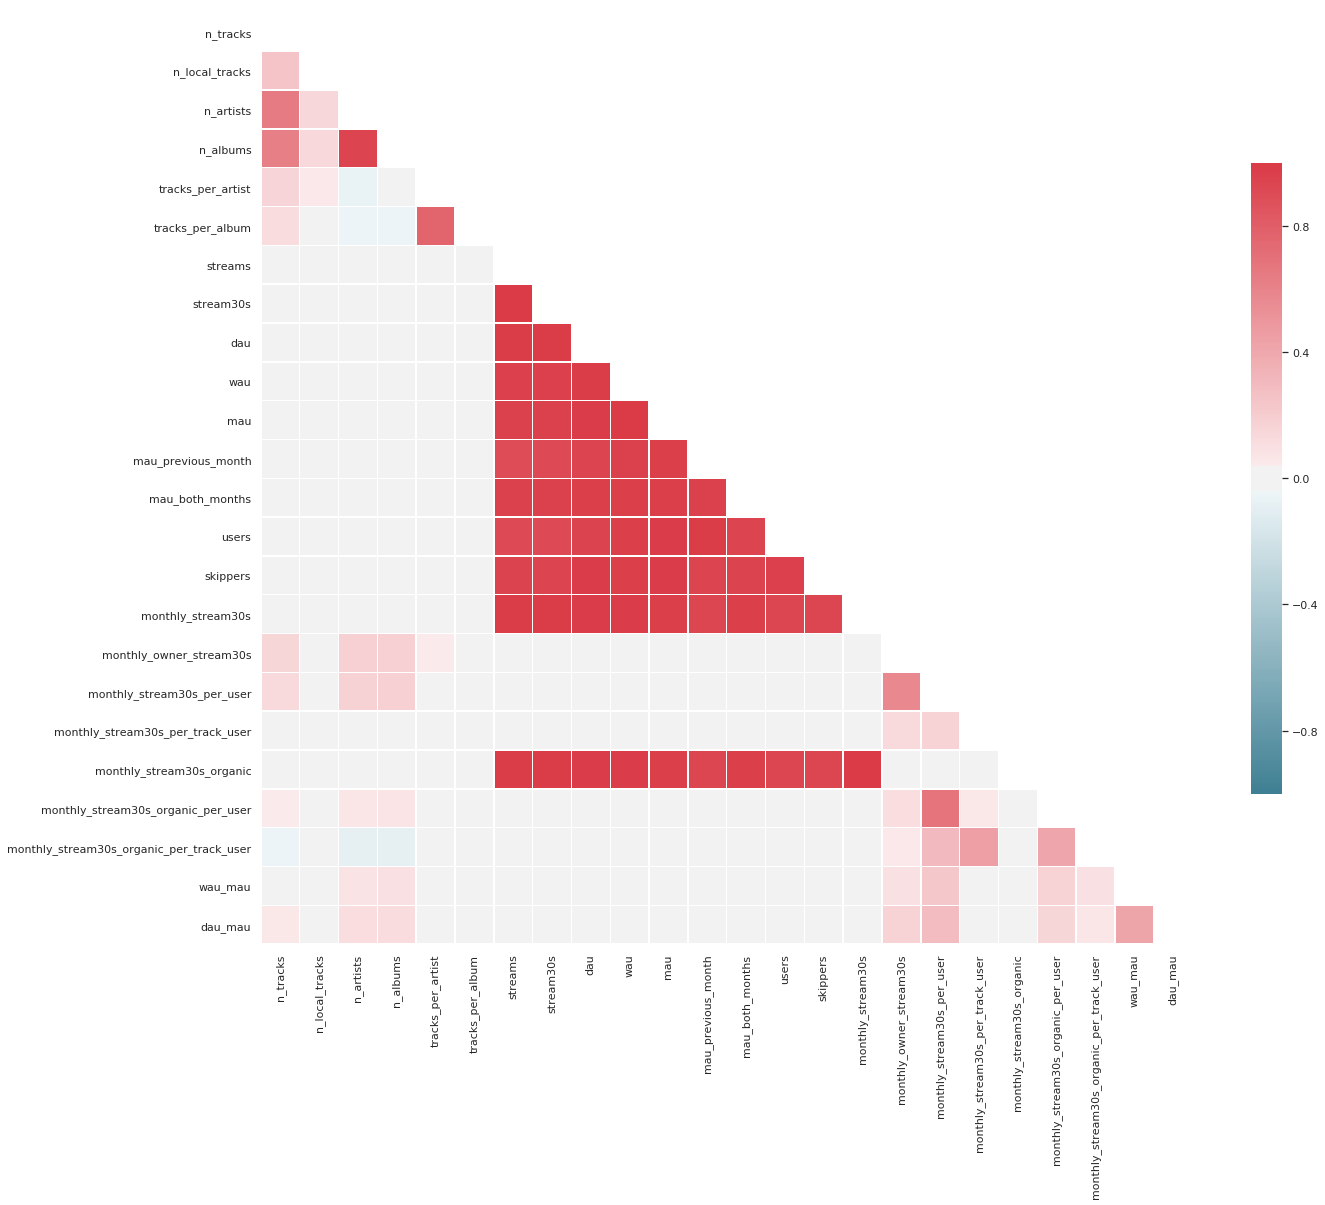

In [18]:
corr = df[number_feature_columns + target_columns].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 20)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()
plt.show()

There is obvious correlation between daily, weekly and monthly average users and monthly streams.  More importantly, there is a positive correlation between number of tracks, albums, and artists with monthly streams and monthly streams per user.  Additionally, there is a negative correlation between number of tracks, albums, and artists and the average number of tracks consumed by the user (monthly_stream30s_organic_per_track_user).  

The scatter plots below show a more detailed picture of the relationship between number of tracks, albums and artists and the engagement metrics.

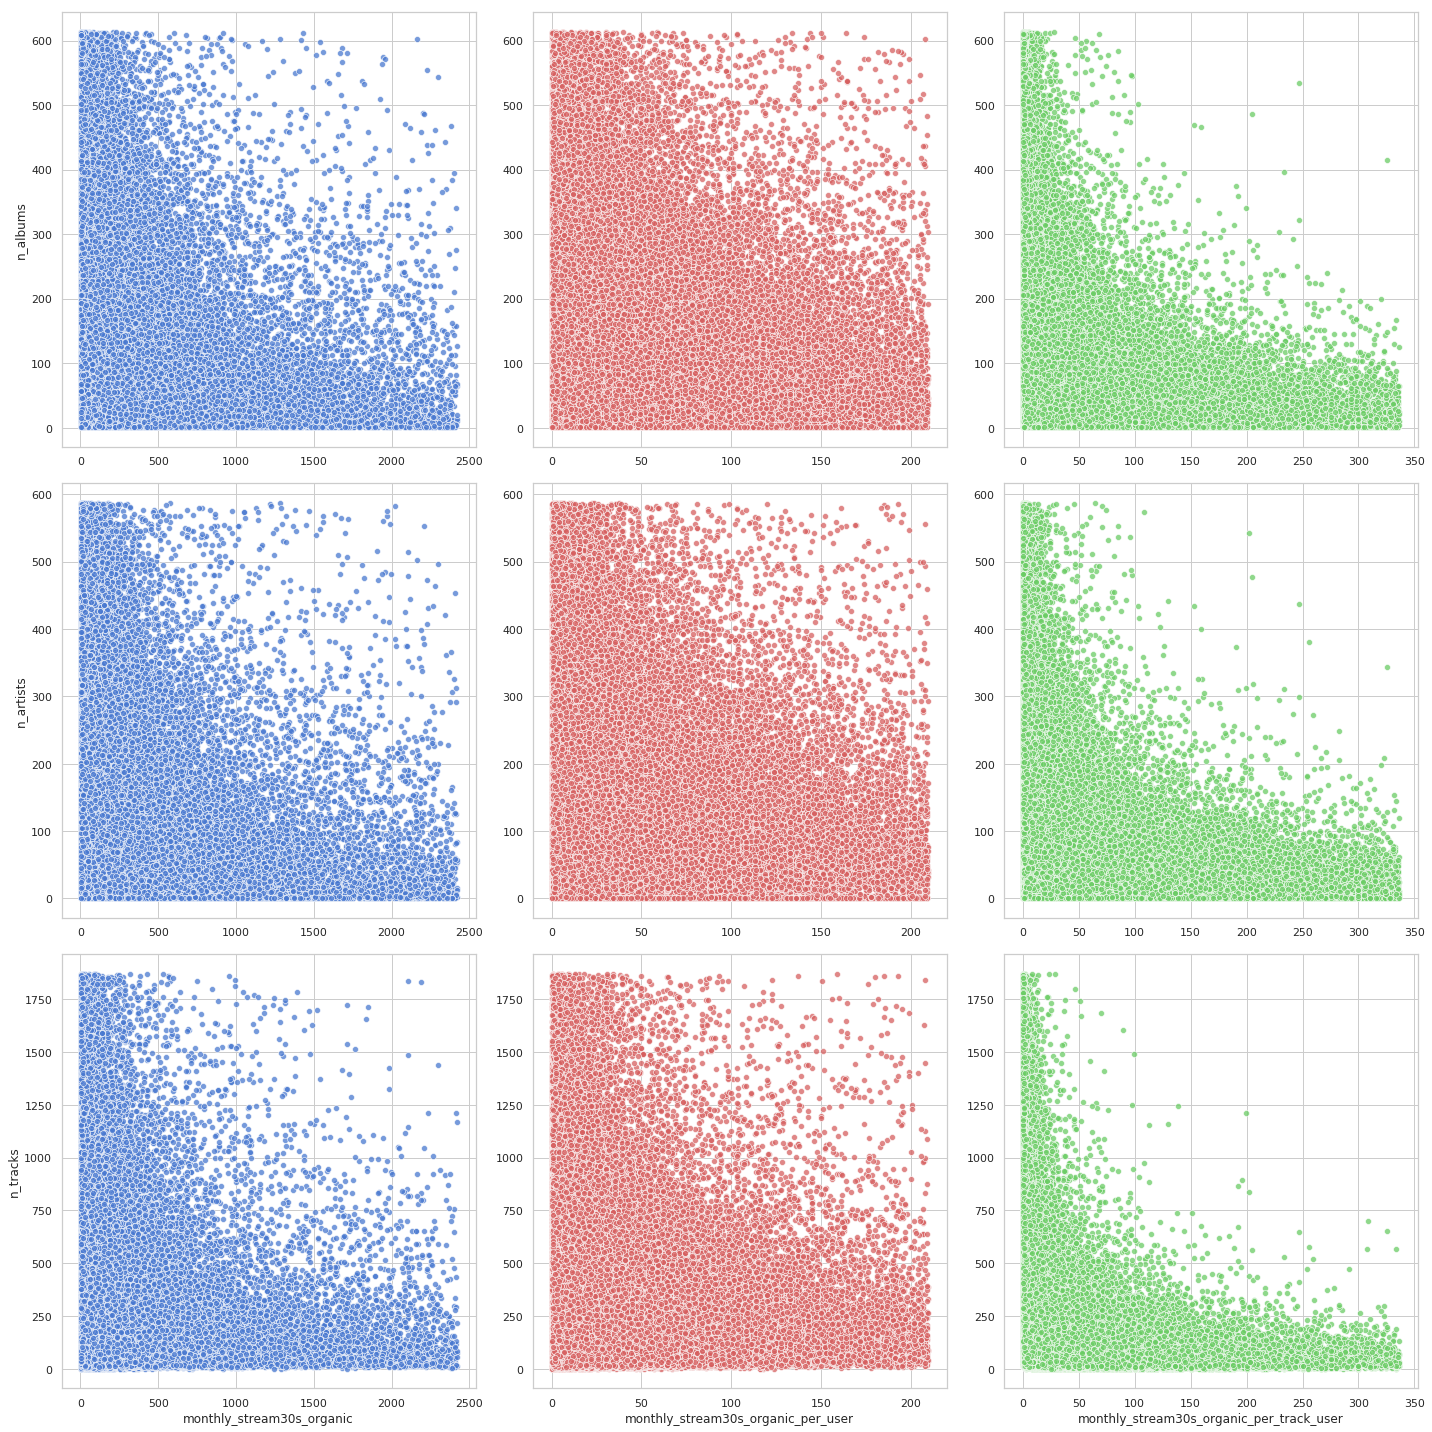

In [19]:
ncols = 3
nrows = 3

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20, 20)

plt_row = 0
plt_col = 0

colors = ['b', 'r', 'g']
row_cols = ['n_albums', 'n_artists', 'n_tracks']
col_cols = ['monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user']

for i, row_col in enumerate(row_cols):
    for j, col_col in enumerate(col_cols):
        my_ax = ax[plt_row][plt_col]
        
        sns.scatterplot(y=row_col, x=col_col, ax=my_ax, color=colors[plt_col], alpha=0.75,
                        data=df[(df[row_col] < df[row_col].quantile(0.99)) & (df[col_col] < df[col_col].quantile(0.99))])    
        
        if plt_col != 0:
            my_ax.set_ylabel('')
            
        if i != len(row_cols) - 1:
            my_ax.set_xlabel('')
        
        plt_col += 1

        if plt_col == ncols:
            plt_col = 0
            plt_row += 1
            
plt.tight_layout()
plt.show()

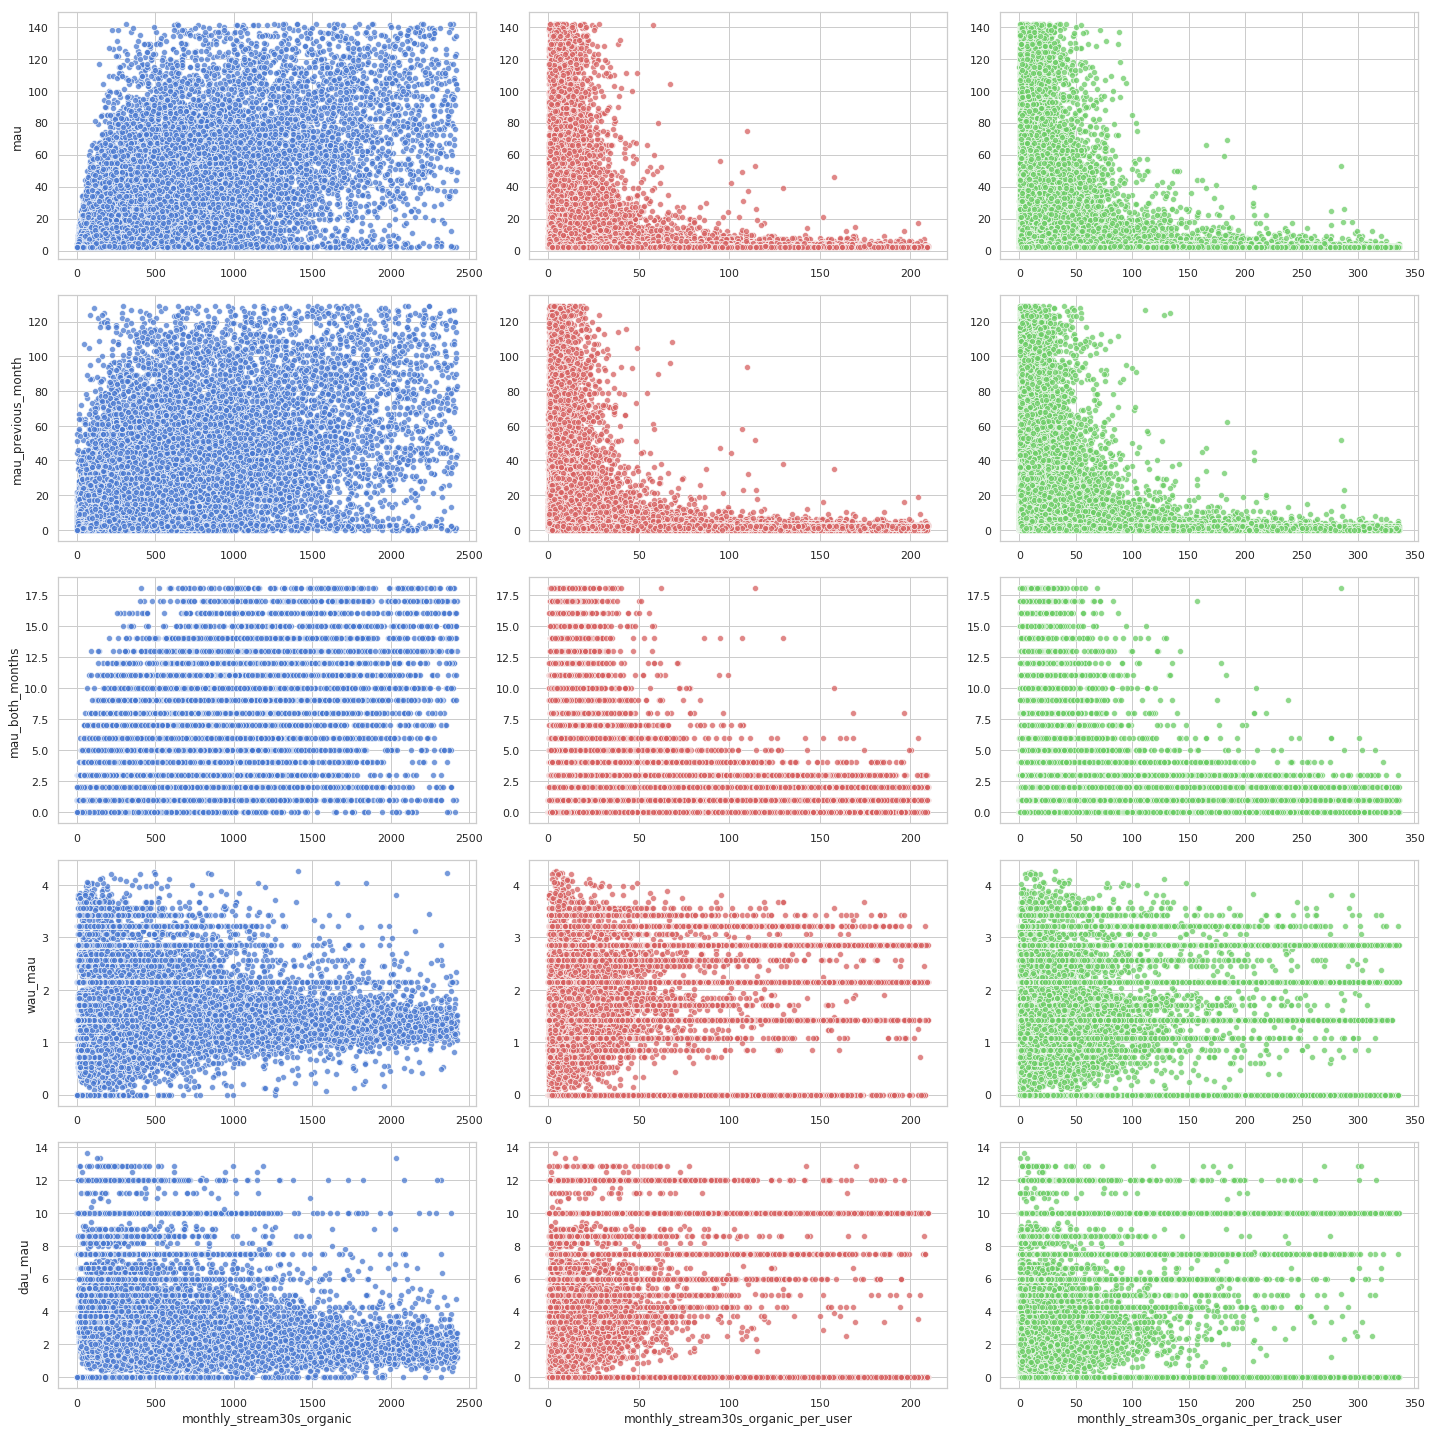

In [20]:
ncols = 3
nrows = 5

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20, 20)

plt_row = 0
plt_col = 0

colors = ['b', 'r', 'g']
row_cols = ['mau', 'mau_previous_month', 'mau_both_months', 'wau_mau', 'dau_mau']
col_cols = ['monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user']

for i, row_col in enumerate(row_cols):
    for j, col_col in enumerate(col_cols):
        my_ax = ax[plt_row][plt_col]
        
        sns.scatterplot(y=row_col, x=col_col, ax=my_ax, color=colors[plt_col], alpha=0.75,
                        data=df[(df[row_col] < df[row_col].quantile(0.99)) & (df[col_col] < df[col_col].quantile(0.99))])    
        
        if plt_col != 0:
            my_ax.set_ylabel('')
            
        if i != len(row_cols) - 1:
            my_ax.set_xlabel('')
        
        plt_col += 1

        if plt_col == ncols:
            plt_col = 0
            plt_row += 1
            
plt.tight_layout()
plt.show()

There does not appear to be a clear linear relationship between numeric features and engagement metrics as the plots are dense for most combinations of values.  These type of plots indicate that explanatory modeling with linear models will be difficult as most combinations of feature variables result in similar outcomes.


The histograms shown below give a more detailed picture of how each of features and target variables are distributed.  Depending on the shape of these distributions, certain transformations like log transforms, z-score standardization, range normalization and binning may be used to improve the effectiveness of linear models.


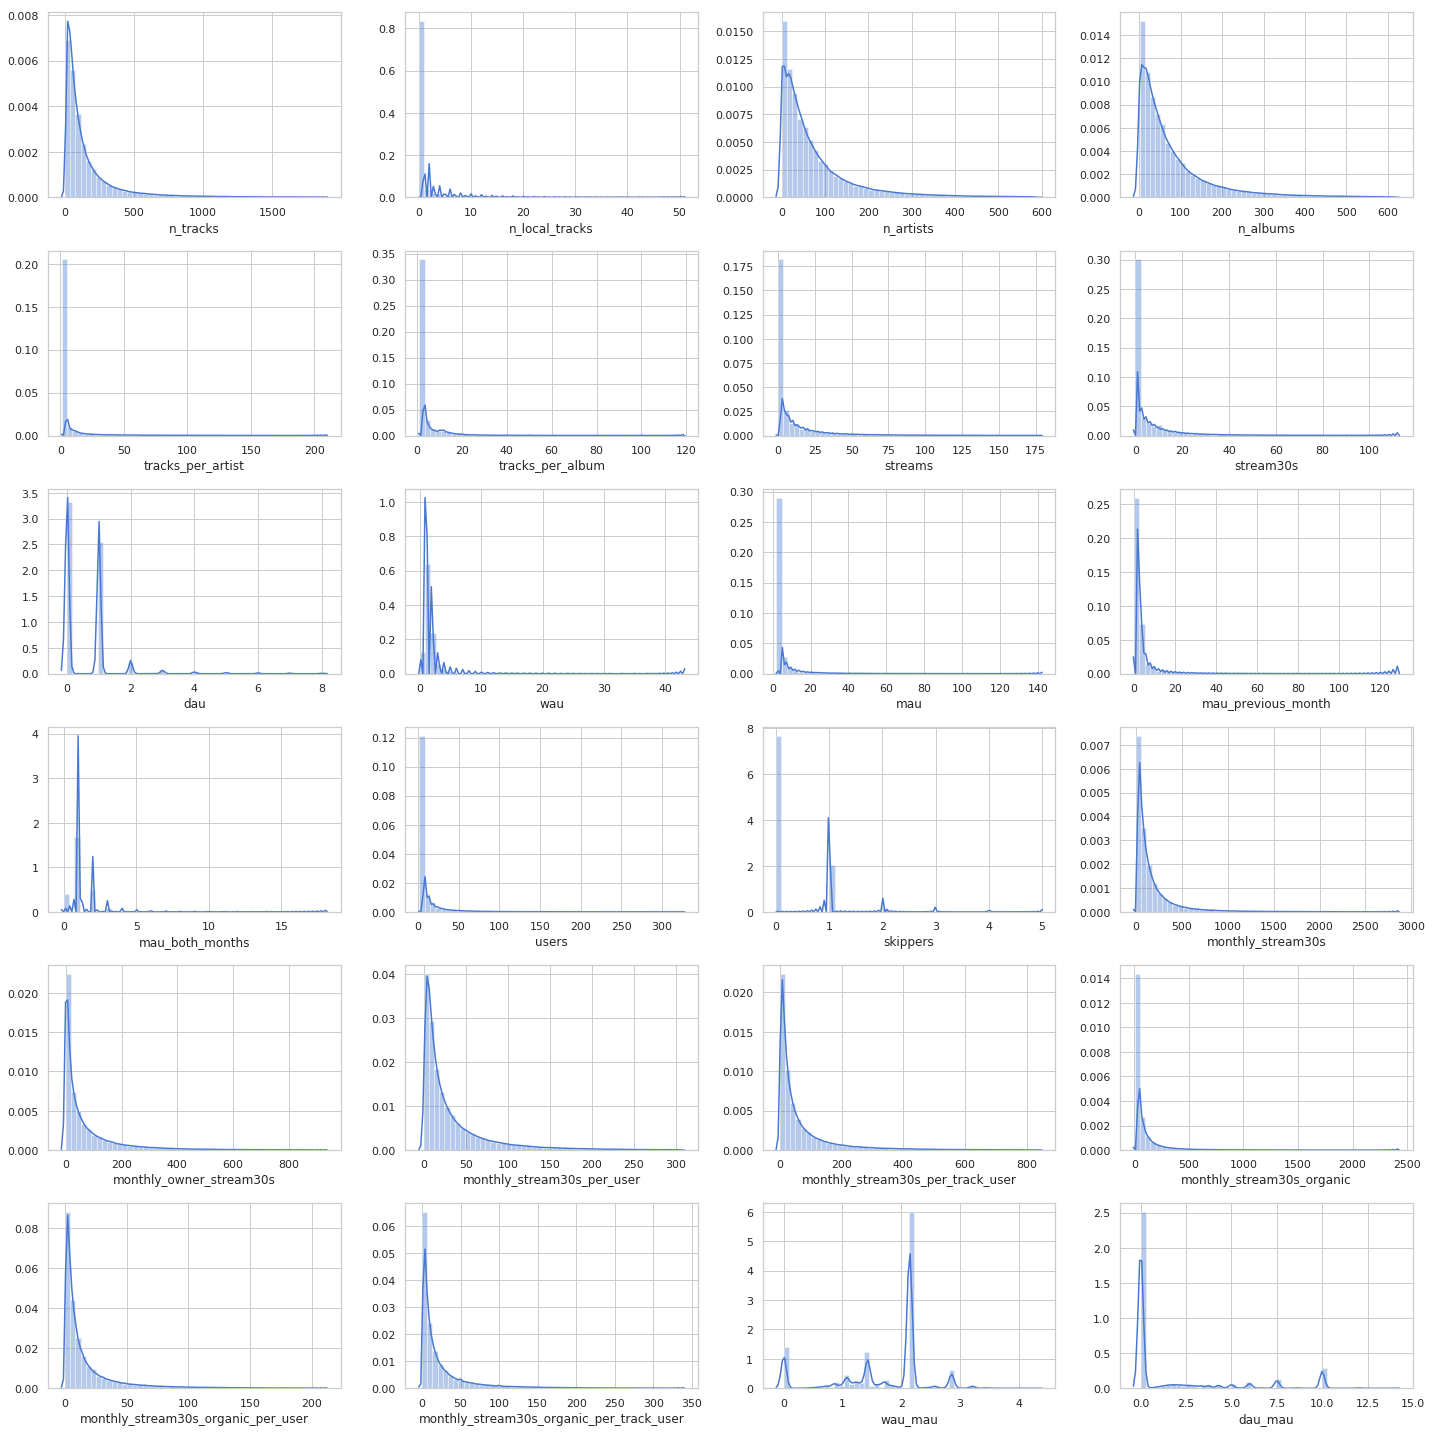

In [21]:
ncols = 4
nrows = 6

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20, 20)

plt_row = 0
plt_col = 0

for col in number_feature_columns + target_columns:
    my_ax = ax[plt_row][plt_col]

    sns.distplot(df[df[col] < df[col].quantile(0.99)][col], ax=my_ax)

    plt_col += 1

    if plt_col == ncols:
        plt_col = 0
        plt_row += 1
            
plt.tight_layout()
plt.show()

Most feature and target variables follow an exponential distributions where outcomes with small values are common while outcomes with large amounts are much rarer.  In addition, most measures have large outliers due to the occasional virality of specific playlists.  As seen with the scatter plots, these distributions will make explanatory modeling using linear regression difficult as most combinations of feature variables result in similar outcomes.



Below are bar graphs that show performance for engagement metrics by genre and mood.  Similar to the goal of the scatter plots, these visualizations attempt to separate performance between genres and moods.

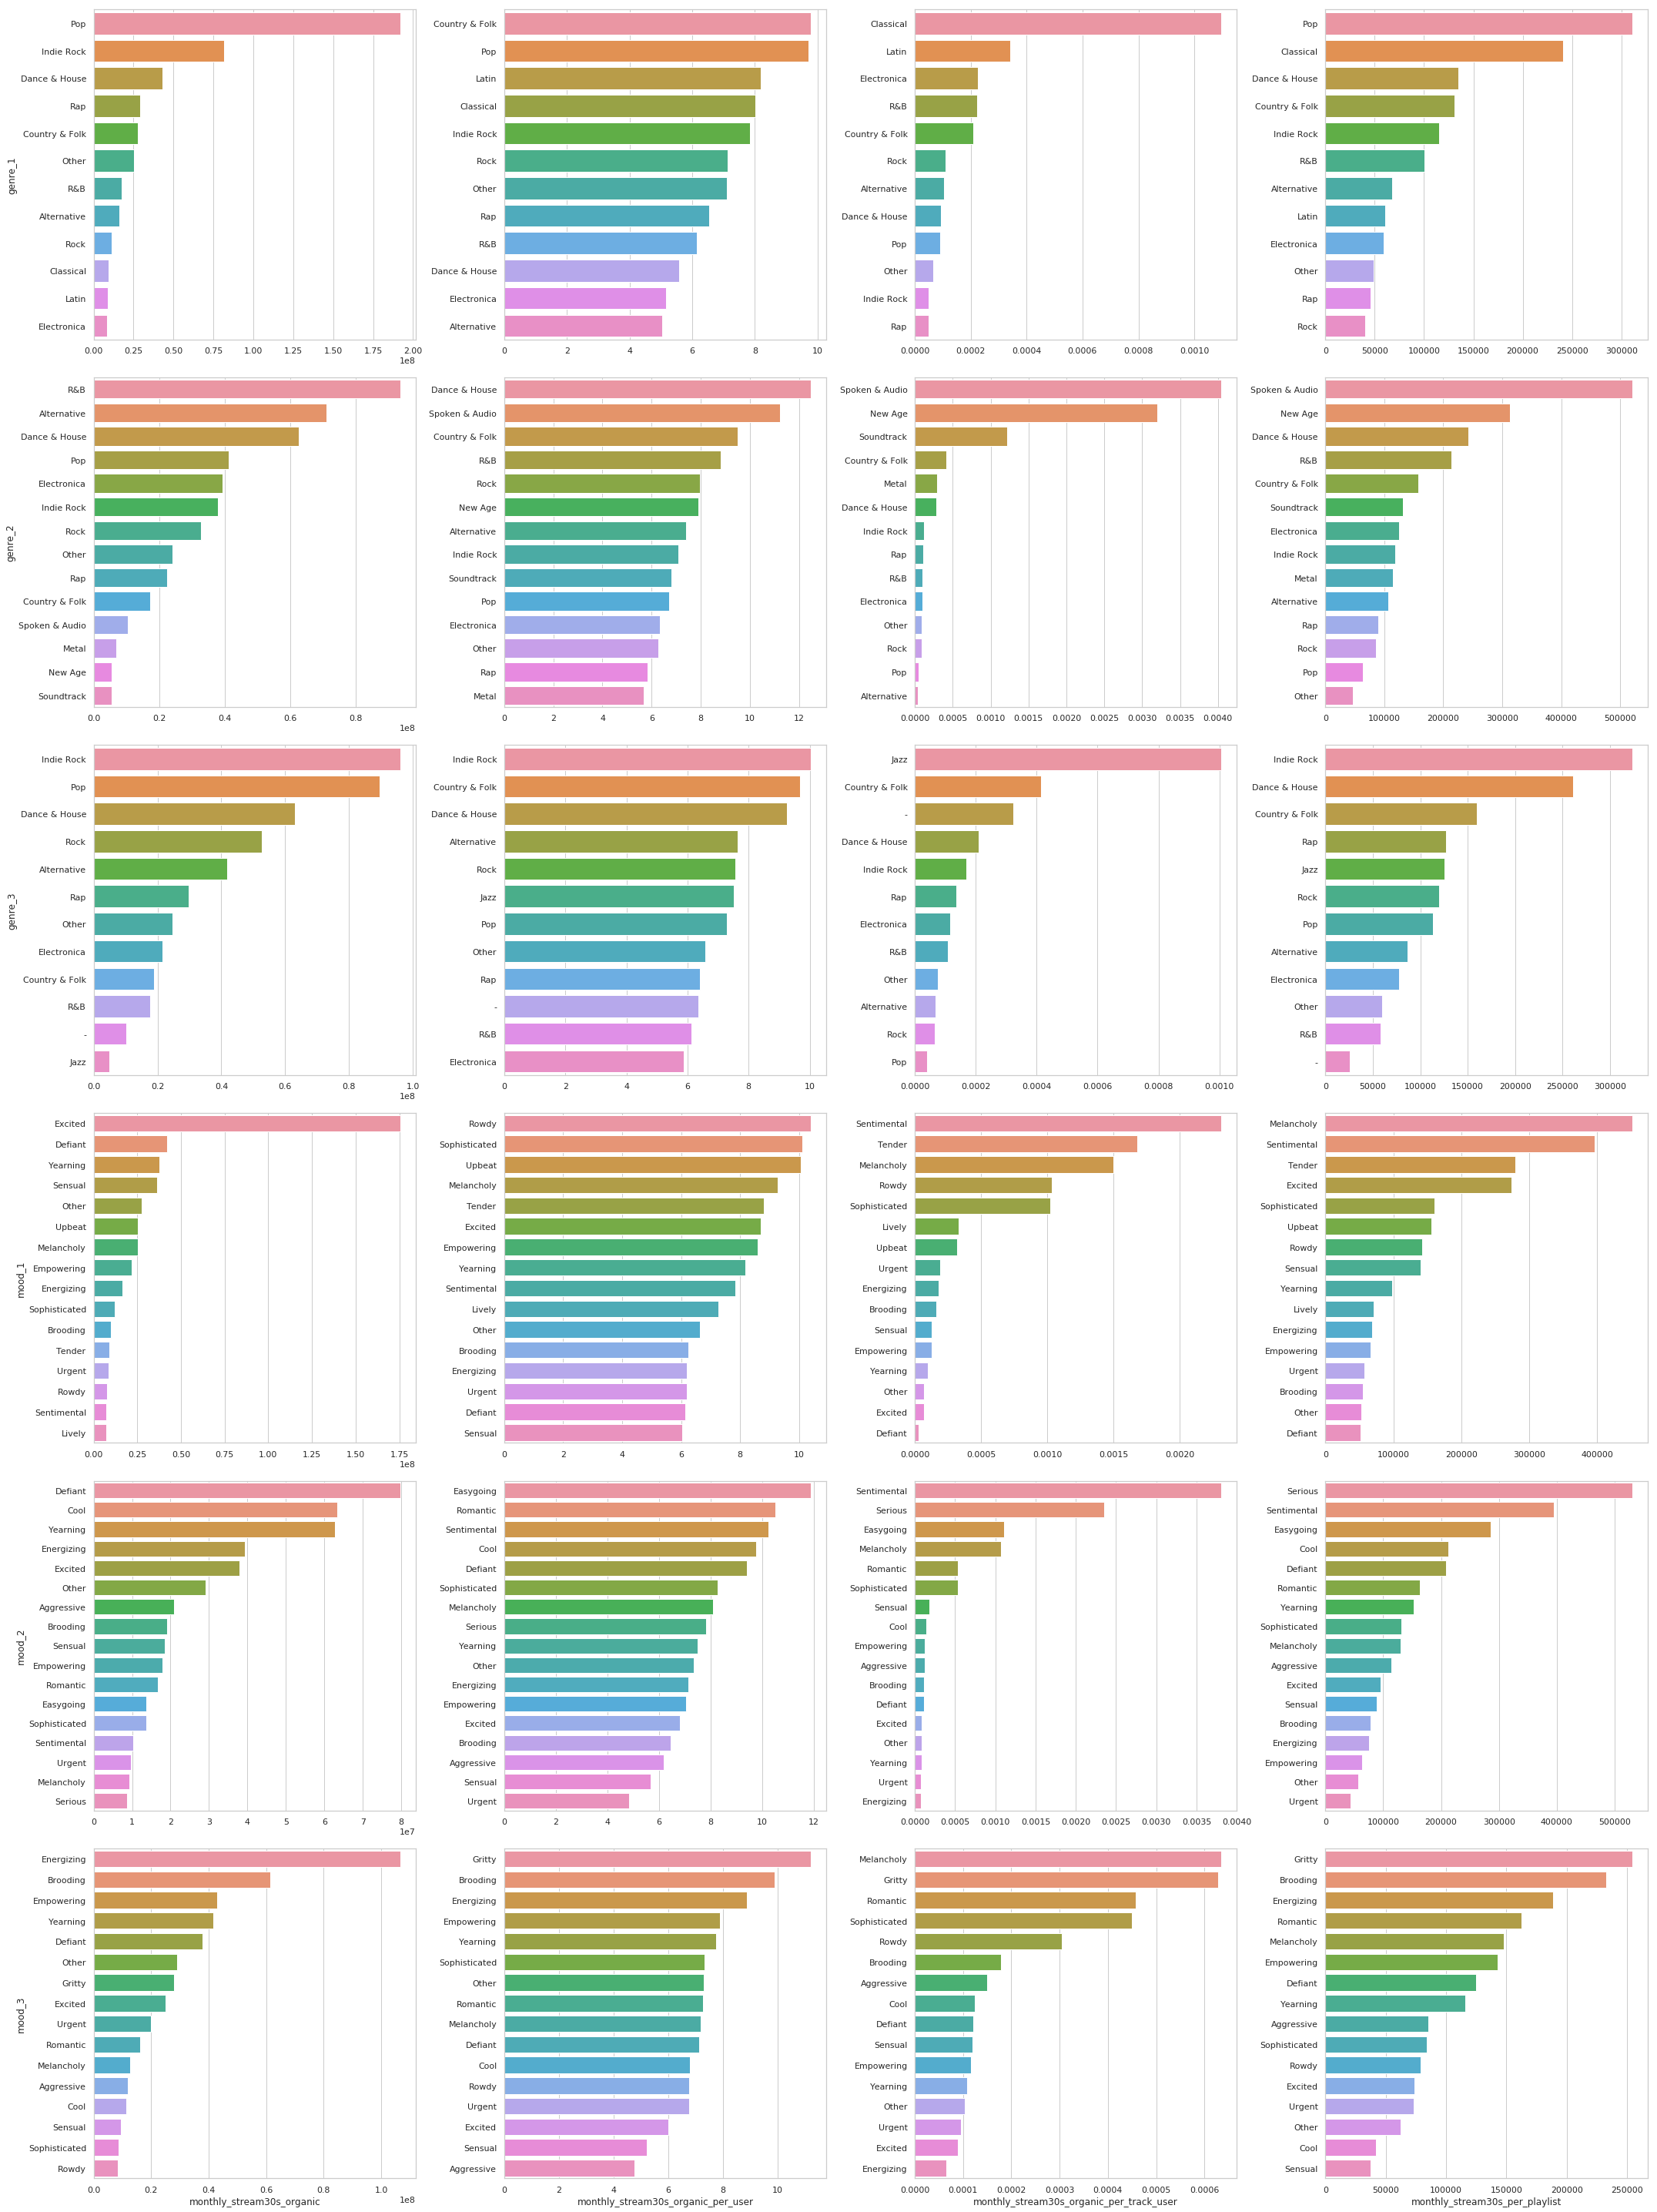

In [22]:
ncols = 4
nrows = 6

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(30, 40)

row_cols = genre_columns + mood_columns
col_cols = ['monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user', 'monthly_stream30s_per_playlist']

plt_row = 0
plt_col = 0

for i, row_col in enumerate(row_cols):
    row_col = row_col + '_trunc'
    df_temp = df.groupby([row_col], as_index=False).agg({'monthly_stream30s_organic': 'sum', 'users': 'sum', 'n_tracks': 'sum', 'playlist_uri': 'count'})
    df_temp['monthly_stream30s_organic_per_user'] = df_temp.monthly_stream30s_organic / (df_temp.users - 1)
    df_temp['monthly_stream30s_organic_per_track_user'] = 100 * df_temp.monthly_stream30s_organic / ((df_temp.users - 1) * df_temp.n_tracks)
    df_temp['monthly_stream30s_per_playlist'] = 100 * df_temp.monthly_stream30s_organic / df_temp.playlist_uri
    
    for j, col_col in enumerate(col_cols):
        my_ax = ax[plt_row][plt_col]

        sns.barplot(x=col_col, y=row_col, data=df_temp, order=df_temp.sort_values([col_col], ascending=False)[row_col], ax=my_ax)
        
        my_ax.set_ylabel(row_col.replace('_trunc', ''))
        
        if plt_col != 0:
            my_ax.set_ylabel('')
            
        if i != len(row_cols) - 1:
            my_ax.set_xlabel('')
        
        plt_col += 1

        if plt_col == ncols:
            plt_col = 0
            plt_row += 1
            
plt.tight_layout()
plt.show()

Genre and mood data, both categorical features, appear to also follow exponential distributions.  It is more likely than not that non-linear models will be able to distinguish the importance of these features.  The bar graphs also confirm the intuition addressed earlier that levels within and across genre and mood are not independent of each other as certain groupings do not appear together.  This can introduce multicollinearity.

Interesting, total number of streams does not translate into higher engagement when looking at streams per user and average tracks per user as there are different sets of values at the top with respect to each.  This portends seeing contrasting groups of important features depending on which engagement metrics is being explained.

Using PCA and MCA, it might be possible to remove sources of multicollinearity.  However, this will be at the expense of interpretability and explanatory power.

In [23]:
std_clf = make_pipeline(preprocessing.StandardScaler(), PCA(n_components=len(number_feature_columns)))
std_clf.fit(df[number_feature_columns])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

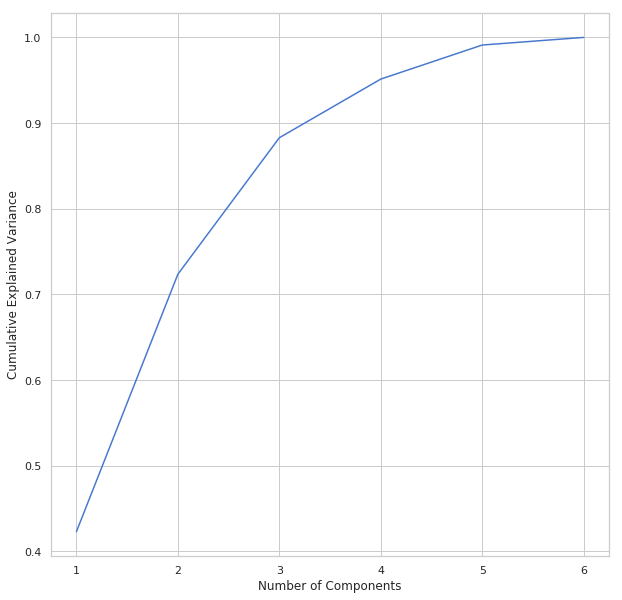

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(1, len(std_clf.named_steps['pca'].explained_variance_ratio_)+1), np.cumsum(std_clf.named_steps['pca'].explained_variance_ratio_))
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')

plt.show()

In [25]:
df_mca = df[[x + '_trunc' for x in genre_mood_columns]]

for col in df_mca.columns:
    if 'genre_mood_trunc' == col:
        col_dummies = pd.get_dummies(df_mca[[col]])
        df_mca = df_mca.merge(col_dummies, how='inner', right_index=True, left_index=True)
    
    df_mca = df_mca.drop([col], axis=1)

df_mca.columns = [re.sub(r'\s+', '_', re.sub(r'&', '', col)).lower() for col in df_mca.columns]
df_mca = reduce_df_mem(df_mca, verbose=False)

In [26]:
mca = prince.MCA(n_components=len(df_mca.columns), random_state=random_state, engine='auto')
mca = mca.fit(df_mca)

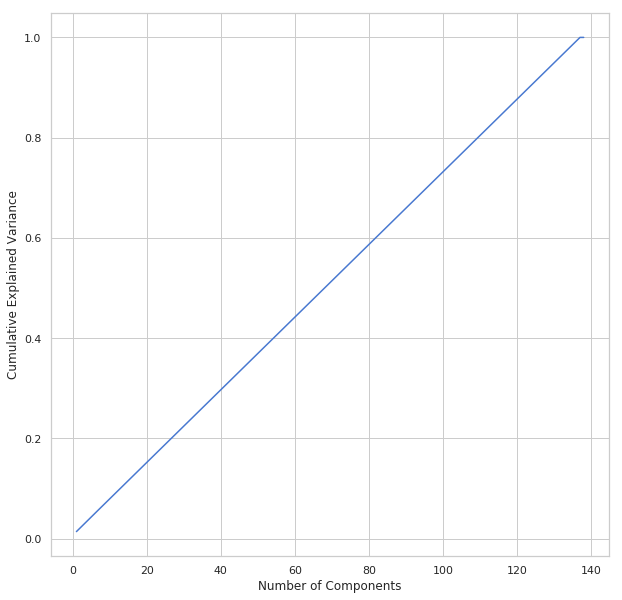

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(1, len(mca.explained_inertia_)+1), np.cumsum(mca.explained_inertia_))
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')

plt.show()

Both PCA and MCA show there is not much gain from dimensionality reduction to make up for the loss in interpretability.

Below sets up the data for linear regression by one hot encoding the genre and mood features as well as winsorizing the numerical features to eliminate the effect of viral playlists and outlier numerical features on the explanatory model.  ElasticNet is used for its ability to take advantage of L1 and L2 normalization for feature reduction/selection.

In [28]:
df_lin_reg = reduce_df_mem(df[[x + '_trunc' for x in genre_mood_columns] + number_feature_columns], verbose=False)

for col in df_lin_reg.columns:
    if 'trunc' in col:
        if col == 'genre_mood_1_trunc':
            col_dummies = reduce_df_mem(pd.get_dummies(df_lin_reg[[col]]), verbose=False)
            df_lin_reg = df_lin_reg.merge(col_dummies, how='inner', right_index=True, left_index=True)

            try:
                df_lin_reg = df_lin_reg.drop(col + '_Other|Other', axis=1)
            except:
                df_lin_reg = df_lin_reg.drop(col_dummies.columns[-1], axis=1)

        df_lin_reg = df_lin_reg.drop([col], axis=1)

df_lin_reg.columns = [re.sub(r'\s+', '_', re.sub(r'&', '', col)).lower() for col in df_lin_reg.columns]

for number_feature_column in number_feature_columns:
    df_lin_reg[number_feature_column] = stats.mstats.winsorize(df_lin_reg[number_feature_column], limits=(0, 0.05), inclusive=(True, True))

In [29]:
df_lin_reg_coefs = pd.DataFrame(columns=['model', 'feature', 'coef', 't_stat', 'p_value'])

for ycol in ['monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user']:
    y = stats.mstats.winsorize(df[ycol], limits=(0, 0.05), inclusive=(True, True))
    X = df_lin_reg

    results_lin_reg = fit_linear_regression(ElasticNet(alpha=0.1, l1_ratio=0.9), X, y)
    print('{0} - R2: {1:0.6f}, P-Value of F statistic: {2:0.6f}, RMSE: {3:0.6f}'.format(ycol, results_lin_reg['r2'], 
                                                                                        results_lin_reg['f_stat_p_value'], 
                                                                                        results_lin_reg['rmse']))
    results_lin_reg['params']['model'] = ycol
    df_lin_reg_coefs = pd.concat([df_lin_reg_coefs, results_lin_reg['params']])
    
df_lin_reg_coefs = df_lin_reg_coefs[['model', 'feature', 'coef', 't_stat', 'p_value']]

monthly_stream30s_organic - R2: 0.027833, P-Value of F statistic: 0.000000, RMSE: 97.813393
monthly_stream30s_organic_per_user - R2: 0.027883, P-Value of F statistic: 0.000000, RMSE: 21.256243
monthly_stream30s_organic_per_track_user - R2: 0.111664, P-Value of F statistic: 0.000000, RMSE: 31.052810


Each model is statistically significant although with very low R2.  Therefore, coefficients might be directionally correct and relative impact of each feature might be correct, but the model only explains a small amount of the variance in engagement.  It is most likely that there are non-linear relationships that cannot be captured by this type of model.  In addition, predictions or estimated values of engagement metrics should not be relied upon because of large errors.

Below are the non-zero, statistically significant coefficients for each of the models.  The sign and magnitude of the coefficients indicate the impact on the model estimate for different genre and moods as well as changes in number of tracks, albums and artists.

In [30]:
df_lin_reg_coefs[(df_lin_reg_coefs.coef != 0) & (df_lin_reg_coefs.p_value <= 0.05)].sort_values(['model', 'coef'], ascending=[True, False])

model                                   feature       coef     t_stat  p_value
0                  monthly_stream30s_organic                                 intercept  45.390868 -15.494435 0.000000
51                 monthly_stream30s_organic           genre_mood_1_trunc_latin|lively  28.118785  39.623262 0.000000
52                 monthly_stream30s_organic         genre_mood_1_trunc_latin|romantic  12.953566  27.548466 0.000000
50                 monthly_stream30s_organic       genre_mood_1_trunc_latin|energizing   7.646826  61.966942 0.000000
53                 monthly_stream30s_organic    genre_mood_1_trunc_latin|sophisticated   4.217747   8.301879 0.000000
24                 monthly_stream30s_organic    genre_mood_1_trunc_country_folk|upbeat   3.196339  11.396581 0.000000
75                 monthly_stream30s_organic   genre_mood_1_trunc_religious|empowering   3.027683  18.117169 0.000000
84                 monthly_stream30s_organic    genre_mood_1_trunc_soundtrack|romantic   2.380986  11.384460 0.000000
6                  monthly_stream30s_organic                          tracks_per_album   1.949293   7.754652 0.000000
58                 monthly_stream30s_organic         genre_mood_1_trunc_pop|empowering   1.820516  22.830918 0.000000
5                  monthly_stream30s_organic                         tracks_per_artist   0.340390  74.940027 0.000000
4                  monthly_stream30s_organic                                  n_albums   0.078025  15.542805 0.000000
3                  monthly_stream30s_organic                                 n_artists   0.056952  27.975594 0.000000
1                  monthly_stream30s_organic                                  n_tracks   0.017784  -8.496522 0.000000
44                 monthly_stream30s_organic      genre_mood_1_trunc_indie_rock|urgent  -0.296968  26.952244 0.000000
2                  monthly_stream30s_organic                            n_local_tracks  -0.748469  10.744446 0.000000
9                  monthly_stream30s_organic    genre_mood_1_trunc_alternative|defiant  -0.996855   9.275143 0.000000
71                 monthly_stream30s_organic               genre_mood_1_trunc_rap|cool  -1.433346  32.354689 0.000000
35                 monthly_stream30s_organic  genre_mood_1_trunc_indie_rock|empowering  -1.628576   8.163305 0.000000
34                 monthly_stream30s_organic     genre_mood_1_trunc_indie_rock|defiant  -2.475477  13.991513 0.000000
60                 monthly_stream30s_organic            genre_mood_1_trunc_pop|excited  -2.674342   9.636615 0.000000
33                 monthly_stream30s_organic    genre_mood_1_trunc_indie_rock|brooding  -3.775896  13.220896 0.000000
45                 monthly_stream30s_organic    genre_mood_1_trunc_indie_rock|yearning  -5.982516  11.989540 0.000000
57                 monthly_stream30s_organic            genre_mood_1_trunc_pop|defiant  -7.626426  35.130381 0.000000
72                 monthly_stream30s_organic            genre_mood_1_trunc_rap|defiant -10.260573  14.872847 0.000000
0   monthly_stream30s_organic_per_track_user                                 intercept  36.446845 -99.992165 0.000000
45  monthly_stream30s_organic_per_track_user    genre_mood_1_trunc_indie_rock|yearning   1.548384  15.881510 0.000000
37  monthly_stream30s_organic_per_track_user     genre_mood_1_trunc_indie_rock|excited   1.507177  48.589590 0.000000
28  monthly_stream30s_organic_per_track_user    genre_mood_1_trunc_dance_house|excited   1.165547  51.082879 0.000000
33  monthly_stream30s_organic_per_track_user    genre_mood_1_trunc_indie_rock|brooding   0.878733  61.534453 0.000000
1   monthly_stream30s_organic_per_track_user                                  n_tracks  -0.030248  -3.748529 0.000178
3   monthly_stream30s_organic_per_track_user                                 n_artists  -0.032271  19.062222 0.000000
4   monthly_stream30s_organic_per_track_user                                  n_albums  -0.039462   4.371326 0.000012
5   monthly_stream30s_organ

Given the low r-squareds from the linear regression, maybe using quantile regression will lead to a better model fit.  Since we are interested in successful playlist, it make sense to target either the top quartile or top decile of playlists for each engagement metric.

In [31]:
df_q_lin_reg_coefs = pd.DataFrame()

for ycol in ['monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user']:
    y = stats.mstats.winsorize(df[ycol], limits=(0, 0.05), inclusive=(True, True))
    X = df_lin_reg
    X = sm.add_constant(X)

    results_q_lin_reg = fit_quantile_regression(X, y, quantile=0.5)
    
    print('{0} - Pseudo R2: {1:0.6f}'.format(ycol, results_q_lin_reg['results'].prsquared))
    
    results_q_lin_reg['params']['model'] = ycol
    df_q_lin_reg_coefs = pd.concat([df_q_lin_reg_coefs, results_q_lin_reg['params']])

df_q_lin_reg_coefs = df_q_lin_reg_coefs[['model', 'feature', 'coef', 't_stat', 'p_value']]

monthly_stream30s_organic - Pseudo R2: 0.010452
monthly_stream30s_organic_per_user - Pseudo R2: 0.017986
monthly_stream30s_organic_per_track_user - Pseudo R2: 0.055732


Similar to the linear regression models previously build, each model is statistically significant although with very low R2.  Therefore, coefficients might be directionally correct and relative impact of each feature might be correct, but the model only explains a small amount of the variance in engagement.  It is most likely that there are non-linear relationships that cannot be captured by this type of model.  In addition, predictions or estimated values of engagement metrics should not be relied upon because of large errors.

Below are the non-zero, statistically significant coefficients for each of the models.  Note that there are significantly more non-zero coefficients for the quantile regression.  The sign and magnitude of the coefficients indicate the impact on the model estimate for different genre and moods as well as changes in number of tracks, albums and artists.

In [32]:
df_q_lin_reg_coefs[(df_q_lin_reg_coefs.coef != 0) & (df_q_lin_reg_coefs.p_value <= 0.05)].sort_values(['model', 'coef'], ascending=[True, False])

model                                     feature      coef     t_stat  p_value
86                 monthly_stream30s_organic       genre_mood_1_trunc_spoken_audio|other 35.247833  11.907438 0.000000
51                 monthly_stream30s_organic             genre_mood_1_trunc_latin|lively 30.848181  39.476684 0.000000
52                 monthly_stream30s_organic           genre_mood_1_trunc_latin|romantic 26.954618  24.200284 0.000000
49                 monthly_stream30s_organic         genre_mood_1_trunc_latin|empowering 26.154771  12.746083 0.000000
53                 monthly_stream30s_organic      genre_mood_1_trunc_latin|sophisticated 25.852910  17.848225 0.000000
87                 monthly_stream30s_organic     genre_mood_1_trunc_traditional|romantic 19.476881  11.526011 0.000000
54                 monthly_stream30s_organic             genre_mood_1_trunc_latin|urgent 17.727453   3.616591 0.000299
22                 monthly_stream30s_organic    genre_mood_1_trunc_country_folk|peaceful 15.713846   3.418867 0.000629
0                  monthly_stream30s_organic                                   intercept 14.657320 116.362572 0.000000
50                 monthly_stream30s_organic         genre_mood_1_trunc_latin|energizing 14.191701  17.416472 0.000000
46                 monthly_stream30s_organic              genre_mood_1_trunc_jazz|lively 11.273771   5.295272 0.000000
84                 monthly_stream30s_organic      genre_mood_1_trunc_soundtrack|romantic  9.621312  10.730484 0.000000
21                 monthly_stream30s_organic      genre_mood_1_trunc_country_folk|lively  8.610032   3.073688 0.002114
75                 monthly_stream30s_organic     genre_mood_1_trunc_religious|empowering  8.143426   6.627668 0.000000
74                 monthly_stream30s_organic              genre_mood_1_trunc_reggae|cool  7.902999   3.962843 0.000074
16                 monthly_stream30s_organic        genre_mood_1_trunc_children's|lively  7.876392   6.322568 0.000000
24                 monthly_stream30s_organic      genre_mood_1_trunc_country_folk|upbeat  6.858485   4.813410 0.000001
85                 monthly_stream30s_organic       genre_mood_1_trunc_soundtrack|serious  6.657779   5.220826 0.000000
18                 monthly_stream30s_organic         genre_mood_1_trunc_classical|tender  3.907177   2.399673 0.016410
65                 monthly_stream30s_organic        genre_mood_1_trunc_pop|sophisticated  3.612424   5.828768 0.000000
37                 monthly_stream30s_organic       genre_mood_1_trunc_indie_rock|excited  2.553991  -6.050660 0.000000
29                 monthly_stream30s_organic      genre_mood_1_trunc_dance_house|sensual  2.235579  -2.147657 0.031742
39                 monthly_stream30s_organic    genre_mood_1_trunc_indie_rock|melancholy  1.973112  -2.960079 0.003076
58                 monthly_stream30s_organic           genre_mood_1_trunc_pop|empowering  1.610196   3.328241 0.000874
61                 monthly_stream30s_organic           genre_mood_1_trunc_pop|melancholy  1.540089   2.207507 0.027279
38                 monthly_stream30s_organic        genre_mood_1_trunc_indie_rock|gritty  1.333476  -4.069138 0.000047
28                 monthly_stream30s_organic      genre_mood_1_trunc_dance_house|excited  1.138420  -4.417714 0.000010
6                  monthly_stream30s_organic                            tracks_per_album  0.573808  26.342250 0.000000
33                 monthly_stream30s_organic      genre_mood_1_trunc_indie_rock|brooding  0.253671 -11.268273 0.000000
5                  monthly_stream30s_organic                           tracks_per_artist  0.246262  12.204419 0.000000
4                  monthly_stream30s_organic                                    n_albums  0.052424  11.133712 0.000000
43                 monthly_stream30s_organic        genre_mood_1_trunc_indie_rock|upbeat  0.039328  -2.611528 0.009014
3                  monthly_stream30s_organic                                   n_artists  0.030062   7.853425 0.

Given the low r-squareds of the linear and quantile regression models, the exponential distribution of features and engagement metrics, and the seeming non-linear relationships between features and engagement metrics, it makes sense to try fitting a tree regression model which can better capture these effects.

Below sets up the data for tree regression by one hot encoding the genre and mood features as well as winsorizing the numerical features to eliminate the effect of viral playlists and outlier numerical features on the explanatory model.  An ensemble algorithm like Random Forest is used to achieve a better explanatory model.

In [33]:
df_ensmb_reg = reduce_df_mem(df[[x + '_trunc' for x in genre_mood_columns] + number_feature_columns], verbose=False)

for col in df_ensmb_reg.columns:
    if 'trunc' in col:
        if col == 'genre_mood_1_trunc':
            col_dummies = reduce_df_mem(pd.get_dummies(df_ensmb_reg[[col]]), verbose=False)
            df_ensmb_reg = df_ensmb_reg.merge(col_dummies, how='inner', right_index=True, left_index=True)

        df_ensmb_reg = df_ensmb_reg.drop([col], axis=1)

df_ensmb_reg.columns = [re.sub(r'\s+', '_', re.sub(r'&', '', col)).lower() for col in df_ensmb_reg.columns]

for number_feature_column in number_feature_columns:
    df_ensmb_reg[number_feature_column] = stats.mstats.winsorize(df_ensmb_reg[number_feature_column], limits=(0, 0.05), inclusive=(True, True))

In [34]:
df_ensmb_coefs = pd.DataFrame()

for ycol in ['monthly_stream30s_organic', 'monthly_stream30s_organic_per_user', 'monthly_stream30s_organic_per_track_user']:
    df_temp, ensmb_r2, ensmb_fstat = run_ensemble_regression(df_ensmb_reg, stats.mstats.winsorize(df[ycol], limits=(0, 0.05), inclusive=(True, True)),
                                                             n_samples_num=1000, n_samples_cat=5000)
    df_temp['model'] = ycol
    df_ensmb_coefs = pd.concat([df_ensmb_coefs, df_temp])
    
    print('{0} - R2: {1:0.6f}, P-Value of F statistic: {2:0.6f}'.format(ycol, ensmb_r2, ensmb_fstat))

df_ensmb_coefs[['model', 'feature', 'coef']]

monthly_stream30s_organic - R2: 0.715454, P-Value of F statistic: 0.000000
monthly_stream30s_organic_per_user - R2: 0.728506, P-Value of F statistic: 0.000000
monthly_stream30s_organic_per_track_user - R2: 0.666409, P-Value of F statistic: 0.000000


feature       coef                                     model
6              genre_mood_1_trunc_latin|lively  61.033685                 monthly_stream30s_organic
60       genre_mood_1_trunc_spoken_audio|other  58.186066                 monthly_stream30s_organic
31           genre_mood_1_trunc_latin|romantic  49.200352                 monthly_stream30s_organic
46         genre_mood_1_trunc_latin|energizing  35.144796                 monthly_stream30s_organic
47      genre_mood_1_trunc_latin|sophisticated  34.500352                 monthly_stream30s_organic
57     genre_mood_1_trunc_traditional|romantic  32.700352                 monthly_stream30s_organic
58         genre_mood_1_trunc_latin|empowering  24.500352                 monthly_stream30s_organic
41      genre_mood_1_trunc_soundtrack|romantic  20.467019                 monthly_stream30s_organic
72    genre_mood_1_trunc_country_folk|peaceful  19.628130                 monthly_stream30s_organic
22     genre_mood_1_trunc_religious|empowering  12.308685                 monthly_stream30s_organic
62              genre_mood_1_trunc_jazz|lively   8.715630                 monthly_stream30s_organic
26        genre_mood_1_trunc_pop|sophisticated   6.533685                 monthly_stream30s_organic
12      genre_mood_1_trunc_country_folk|upbeat   6.282574                 monthly_stream30s_organic
59       genre_mood_1_trunc_soundtrack|serious   5.033685                 monthly_stream30s_organic
10           genre_mood_1_trunc_pop|empowering   4.300352                 monthly_stream30s_organic
4                            tracks_per_artist   3.642858                 monthly_stream30s_organic
5                             tracks_per_album   3.502803                 monthly_stream30s_organic
69        genre_mood_1_trunc_children's|lively   3.478130                 monthly_stream30s_organic
66       genre_mood_1_trunc_jazz|sophisticated   3.405907                 monthly_stream30s_organic
56      genre_mood_1_trunc_country_folk|lively   3.367019                 monthly_stream30s_organic
67           genre_mood_1_trunc_pop|melancholy   1.367019                 monthly_stream30s_organic
2                                    n_artists   0.013655                 monthly_stream30s_organic
0                                     n_tracks   0.000000                 monthly_stream30s_organic
0               genre_mood_1_trunc_other|other   0.000000                 monthly_stream30s_organic
3                                     n_albums  -0.003000                 monthly_stream30s_organic
27            genre_mood_1_trunc_metal|defiant  -0.391315                 monthly_stream30s_organic
1                               n_local_tracks  -1.025361                 monthly_stream30s_organic
32              genre_mood_1_trunc_rock|upbeat  -1.199648                 monthly_stream30s_organic
18      genre_mood_1_trunc_electronica|sensual  -1.266315                 monthly_stream30s_organic
63         genre_mood_1_trunc_jazz|sentimental  -2.199648                 monthly_stream30s_organic
55         genre_mood_1_trunc_classical|tender  -2.407981                 monthly_stream30s_organic
54              genre_mood_1_trunc_reggae|cool  -2.466315                 monthly_stream30s_organic
75     genre_mood_1_trunc_electronica|peaceful  -2.657981                 monthly_stream30s_organic
5              genre_mood_1_trunc_pop|yearning  -2.721077                 monthly_stream30s_organic
37              genre_mood_1_trunc_rap|sensual  -3.332981                 monthly_stream30s_organic
36  genre_mood_1_trunc_country_folk|empowering  -3.692981                 monthly_stream30s_organic
14          genre_mood_1_trunc_rock|empowering  -3.766315                 monthly_stream30s_organic
7                genre_mood_1_trunc_rb|sensual  -3.766315                 monthly_stream30s_organic
52      genre_mood_1_trunc_country_folk|gritty  -4.734800                 monthly_stream30s_organic
2               genre_mood_1_trunc_pop|

Random Forest generates models with significantly higher r-squareds which seemingly better capture the non-linear relationships in the data.  The relative weighting of features appears consistent across the different algorithms when comparing the bootstrap coefficients from the Random Forest models with those of the linear and quantile regressions.  Some combination of these weightings can therefore be used confidently to drive the decision on what type of playlists the company should focus on in order to optimize user engagement. 